In [233]:
from scripts import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import seaborn as sns

In [192]:
# load the 2012 data set and look for a day with few measurements
df_2012 = pd.read_csv('data/2012_all_v2.csv')

df_2012

,utc,star,elevation,azimuth,tel_1,tel_2,pop_1,pop_2,cart_1,cart_2,year,month,day
0,2012-02-03T02:25:39.000,#57100,0.713447,2.464114,S1,W1,P4B5,P1B6,87.558149,23.999987,2012,2,3
1,2012-02-03T02:25:40.000,#57100,0.713485,2.464196,S1,W1,P4B5,P1B6,87.551523,23.999987,2012,2,3
2,2012-02-03T02:25:41.000,#57100,0.713523,2.464278,S1,W1,P4B5,P1B6,87.544909,23.999987,2012,2,3
3,2012-02-03T02:46:21.000,#57100,0.757257,2.570060,S1,W1,P4B5,P1B6,78.534254,23.999992,2012,2,3
4,2012-02-03T02:46:39.000,#57100,0.757843,2.571662,S1,W1,P4B5,P1B6,78.391951,23.999992,2012,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22270,2012-12-22T11:46:22.000,#153578,0.929092,0.703750,S1,E1,P1B4,P5B6,6.688514,31.956417,2012,12,22
22271,2012-12-22T11:46:22.000,#153578,0.929092,0.703750,S1,W1,P1B4,P3B5,6.688514,0.000000,2012,12,22
22272,2012-12-22T11:47:28.000,#153578,0.931664,0.702383,E1,W1,P5B6,P3B5,31.282386,0.000000,2012,12,22
22273,2012-12-22T11:47:28.000,#153578,0.931664,0.702383,S1,E1,P1B4,P5B6,6.588786,31.282386,2012,12,22


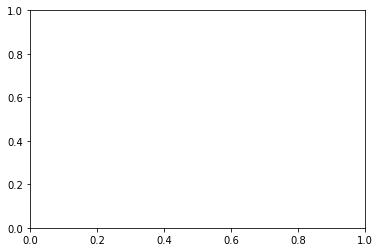

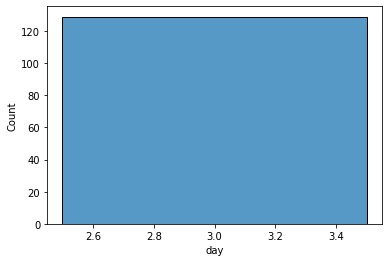

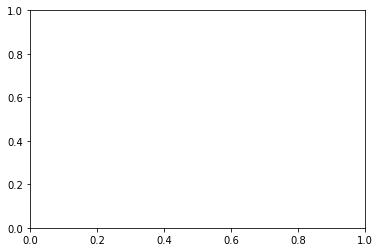

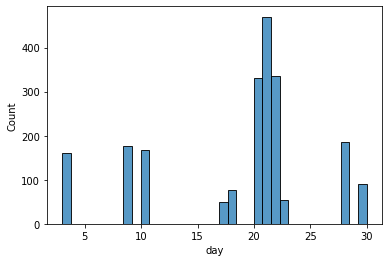

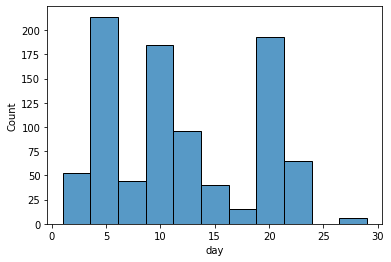

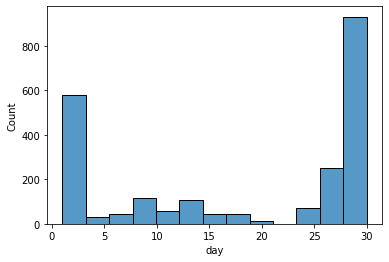

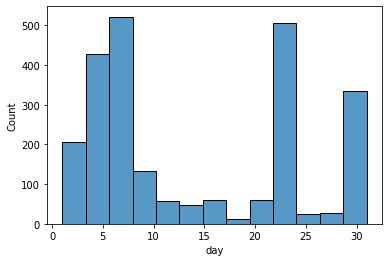

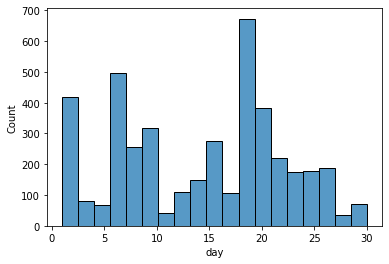

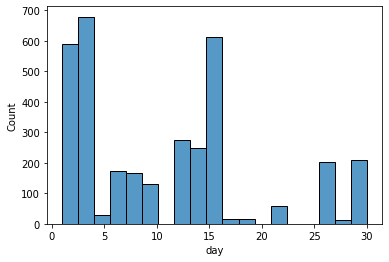

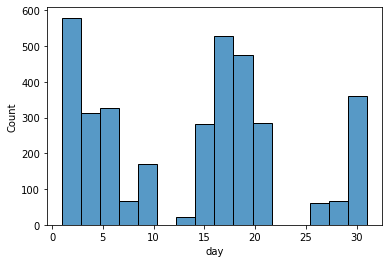

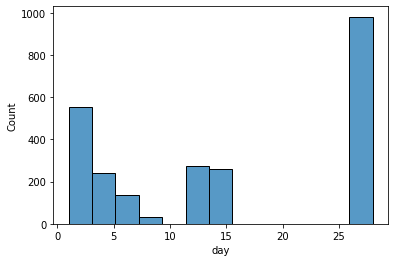

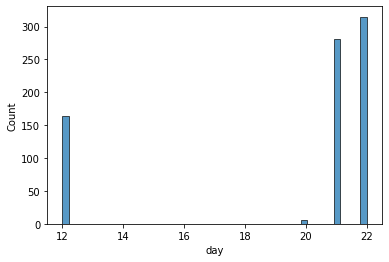

In [232]:
# look at the amount of measurements per day for the whole of 2012
for month in range(1,13):
    sns.histplot(df_2012[df_2012.month==month].day)
    plt.show()

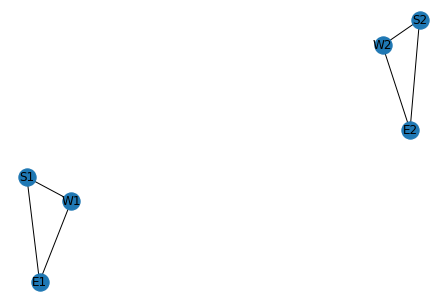

In [237]:
df = df_2012[(df_2012.month == 5) & (df_2012.day == 4)]

graph_df = df.groupby(['tel_1','tel_2']).size().reset_index().rename(columns={0:'count'})
G = nx.from_pandas_edgelist(graph_df, source='tel_1', target='tel_2')

nx.draw(G, with_labels=True)
plt.show()

In [212]:
nx.is_connected(G)

False

In [214]:
# we can see that the graph is disconnected and this is what the function tell us
# lets solve this problem and see if the degeneracies are observable 

design_mat, pinv, y, beta = create_design_mat(df)

In [215]:
beta

array([  67.61217185,  -31.79130762,   -1.02954313,  300.40057979,
         89.61262469,    4.87404459,    4.26467806,  133.96299754,
         -1.20360091,  125.33081666,  305.93213165,   -5.91536702,
        -71.87684991, -102.17168991,    2.23314404,   49.39169636,
          8.18047333,  -46.89531862,  -14.85382856,   -2.49637774,
          6.67335523])

In [221]:
# see that the model is predicting the outcomes well
max(y - design_mat @ beta) 

0.00014834138899288973

In [230]:
# here E2, W2 and S2 are only ever seen together -> and they are not zero'd out 
# expect these to be the ones with strange values
loc_actual = np.array([
    #[0,0,0], # E1
    [194.451, 106.618, - 6.318], # W2
    [300.442, 89.639, 4.954], # W1
    [131.120, 272.382, -6.508], # S2
    [125.371, 305.963, -5.865], # S1
    [54.970, 36.246, -3.077], # E2
])


# so we see that the large errors come for the 1st, 3rd and 5th baselines 
# these correspond to W2, S2 and E2 i.e. disconnected graphs do not perform well!
# but important to remember that the basleines of E2 S2 W2 will still be correct (atleast not really wrong!)
loc_actual.reshape(-1,) - beta[:15]

array([ 1.26838828e+02,  1.38409308e+02, -5.28845687e+00,  4.14202103e-02,
        2.63753079e-02,  7.99554112e-02,  1.26855322e+02,  1.38419002e+02,
       -5.30439909e+00,  4.01833361e-02,  3.08683502e-02,  5.03670226e-02,
        1.26846850e+02,  1.38417690e+02, -5.31014404e+00])

In [248]:
# in the SVD these degeneracies should show themselves as zero singular values 

U, w, Vt = np.linalg.svd(design_mat)

# see that we have 5 zero singular values ad 4 others that are very small
# something in numerical recipes about getting rid of the smaller ones
w

array([1.54374390e+01, 1.35306077e+01, 1.35306077e+01, 1.26915929e+01,
       1.65442388e+00, 1.65442388e+00, 1.54191481e+00, 8.84498233e-01,
       5.73478508e-01, 4.21381312e-01, 4.21381312e-01, 3.37327118e-01,
       8.93053939e-02, 8.93053939e-02, 6.55140054e-02, 4.63610753e-02,
       1.09848269e-15, 7.69188646e-16, 7.14050421e-16, 1.17870290e-16,
       6.57237396e-17])

In [315]:
# looking at the v vectors that correpond to these zero singular values 
# v vectors are the columns of V and are therefore the rows of Vt

Vt[-1] 

array([ 1.16920833e-01, -5.65238206e-01, -8.47978165e-03, -2.99682401e-16,
        1.01543328e-16, -2.15467782e-16,  1.16920833e-01, -5.65238206e-01,
       -8.47978165e-03, -1.34975576e-16, -1.45147341e-16, -2.16471839e-16,
        1.16920833e-01, -5.65238206e-01, -8.47978165e-03, -6.45531842e-04,
       -9.81324089e-03, -6.45531842e-04, -9.81324089e-03, -6.45531842e-04,
       -9.81324089e-03])

In [287]:
np.where(abs(Vt[-1]) > 0.00001)
# this has contributions from W2, S2, E2 and ALL the pop settings
# turns out that it is the same for the rest of them... 

(array([ 0,  1,  2,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 20]),)

In [322]:
V1 = Vt[-1]

V1 = V1[abs(V1) > 0.00001]

# now for the first col we get the values that are significant
V1 / min(abs(V1)) 

# has large values for x and very large values for y componenets

array([ 181.12326188, -875.61630368,  -13.13611675,  181.12326188,
       -875.61630368,  -13.13611675,  181.12326188, -875.61630368,
        -13.13611675,   -1.        ,  -15.20179215,   -1.        ,
        -15.20179215,   -1.        ,  -15.20179215])

In [323]:
V2 = Vt[-2]

V2 = V2[abs(V2) > 0.00001]

# now for the first col we get the values that are significant
V2 / min(abs(V2))

# has very large values for x, large for y 

array([ 1.29393295e+03,  2.69318602e+02, -3.12864863e+01,  1.29393295e+03,
        2.69318602e+02, -3.12864863e+01,  1.29393295e+03,  2.69318602e+02,
       -3.12864863e+01,  1.00000000e+00, -6.89668531e+01,  1.00000000e+00,
       -6.89668531e+01,  1.00000000e+00, -6.89668531e+01])

In [335]:
V3 = Vt[-3]

V3 = V3[abs(V3) > 0.00001]

# now for the first col we get the values that are significant
V3 / min(abs(V3))

# the smallest value here is in the y component
# largest valeus here are z components 
# note that all the baseline vectors and pop settings have the same value here 

array([ 5.63121414, -1.        , 55.38152132,  5.63121414, -1.        ,
       55.38152132,  5.63121414, -1.        , 55.38152132,  2.67542998,
       76.66113355,  2.67542998, 76.66113355,  2.67542998, 76.66113355])

In [325]:
V4 = Vt[-4]

V4 = V4[abs(V4) > 0.00001]

# now for the first col we get the values that are significant
V4 / min(abs(V4))

# again the basline has the same values for all of the the telescopes
# large values for z components comparible with the pop 

array([   2.5283285 ,    1.        , -186.14286938,    2.5283285 ,
          1.        , -186.14286938,    2.5283285 ,    1.        ,
       -186.14286938,  -30.01886177,  135.34826075,  -30.01886177,
        135.34826075,  -30.01886177,  135.34826075])

In [336]:
V5 = Vt[-5]

V5 = V5[abs(V5) > 0.00001]

# now for the first col we get the values that are significant
V5 / min(abs(V5))
# here the z component fo the pop is large and they are all the same 
# though the pop settings is by far the largest

array([-1.98345486e+00, -1.00000000e+00, -3.05606972e+02, -1.98345486e+00,
       -1.00000000e+00, -3.05606972e+02, -1.98345486e+00, -1.00000000e+00,
       -3.05606972e+02,  2.49781592e+03,  1.33736826e+02,  2.49781592e+03,
        1.33736826e+02,  2.49781592e+03,  1.33736826e+02])

In [ ]:
# only one POP setting is used for each telescope